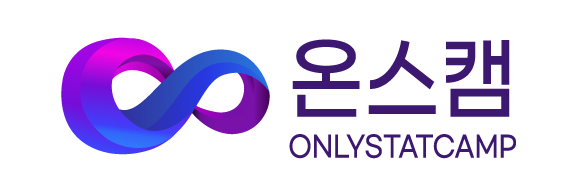

<img src="https://upload.wikimedia.org/wikipedia/commons/e/e6/Lightning_Logo_v2.png?20211005181334" height="100">

PyTorch 자체에는 model.fit()과 같은 고수준 API가 없지만, PyTorch와 호환되는 라이브러리인 PyTorch Lightning을 사용하면 이를 유사하게 구현할 수 있습니다.   
PyTorch Lightning은 학습 루프와 같은 반복적인 코드를 단순화하고, 모델 훈련을 더 간단하게 만들 수 있습니다.

In [ ]:
!pip install pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.3/802.3 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 27.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-many

In [ ]:
import pytorch_lightning as pl

import torch
import torch.nn.functional as F
from torch import nn
from torch.optim import SGD
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets

PyTorch Lightning에서 모델을 정의하려면 LightningModule 클래스를 상속받아야 합니다.  



In [ ]:
class EnhancedCNN(pl.LightningModule):
    def __init__(self):
        super(EnhancedCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 64 * 7 * 7)  # Flatten the tensor
        x = self.dropout(F.relu(self.bn3(self.fc1(x))))
        x = self.fc2(x)
        return x


    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = F.cross_entropy(outputs, labels)
        self.log('train_loss', loss)
        return loss


    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = F.cross_entropy(outputs, labels)
        self.log('val_loss', loss)
        return loss


    def test_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = F.cross_entropy(outputs, labels)
        self.log('test_loss', loss)
        return loss


    def configure_optimizers(self):
        return SGD(self.parameters(), lr=0.01, momentum=0.9)


PyTorch Lightning은 데이터 준비 및 로딩을 위한 헬퍼 함수도 제공합니다.



In [ ]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, batch_size=32):
        super().__init__()
        self.batch_size = batch_size
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

    def prepare_data(self):
        datasets.MNIST(root='./data', train=True, download=True)
        datasets.MNIST(root='./data', train=False, download=True)

    def setup(self, stage=None):
        mnist_full = datasets.MNIST(root='./data', train=True, transform=self.transform)
        self.train_set, self.val_set = random_split(mnist_full, [55000, 5000])
        self.test_set = datasets.MNIST(root='./data', train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.train_set, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.val_set, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_set, batch_size=self.batch_size)


PyTorch Lightning은 Trainer 클래스를 사용하여 모델 학습을 관리합니다.



In [ ]:
# 데이터 모듈
mnist_data = MNISTDataModule()

In [ ]:
# 모델 초기화
model = EnhancedCNN()

In [ ]:
print(model)

EnhancedCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:
# Trainer 초기화
trainer = pl.Trainer(max_epochs=2)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
# 모델 학습
trainer.fit(model, mnist_data)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 87079764.84it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 22263498.22it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden




100%|██████████| 1648877/1648877 [00:00<00:00, 41693391.99it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 6919916.01it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type        | Params
----------------------------------------
0 | conv1   | Conv2d      | 320   
1 | bn1     | BatchNorm2d | 64    
2 | conv2   | Conv2d      | 18.5 K
3 | bn2     | BatchNorm2d | 128   
4 | pool    | MaxPool2d   | 0     
5 | dropout | Dropout     | 0     
6 | fc1     | Linear      | 401 K 
7 | bn3     | BatchNorm1d | 256   
8 | fc2     | Linear      | 1.3 K 
----------------------------------------
422 K     Trainable params
0         Non-trainable params
422 K     Total params
1.688     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


In [ ]:
# 모델 평가
trainer.test(model, datamodule=mnist_data)

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.03159676119685173    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.03159676119685173}]